# Movie Recommendation by NLP
In this script, we try to apply content based filtering to recommend movies to Netflix users. The original dataset is available at https://www.kaggle.com/shivamb/netflix-shows. We take advantage of natural language processing framework. 

In [6]:
#Adding libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import collections
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
# Overview of dataset
movieData = pd.read_csv('netflix_titles.csv')
movieData.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [19]:
#Selecting all movies
movies = movieData.loc[movieData.type=='Movie',:].reset_index()
movies.title = movies.title.str.lower()
movies['index'] = movies.index
movies.head()

,index,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,0,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
1,1,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
2,2,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
3,3,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
4,4,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ..."


In [20]:
#Selecting all TV shows
TVshows = movieData.loc[movieData.type=='TV Show',:].reset_index()
TVshows.title = TVshows.title.str.lower()
TVshows['index'] = TVshows.index
TVshows.head()

,index,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,1,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...
2,2,s12,TV Show,1983,NaN,"Robert Więckiewicz, Maciej Musiał, Michalina O...","Poland, United States","November 30, 2018",2018,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas","In this dark alt-history thriller, a naïve law..."
3,3,s13,TV Show,1994,Diego Enrique Osorno,NaN,Mexico,"May 17, 2019",2019,TV-MA,1 Season,"Crime TV Shows, Docuseries, International TV S...",Archival video and new interviews examine Mexi...
4,4,s17,TV Show,feb-09,NaN,"Shahd El Yaseen, Shaila Sabt, Hala, Hanadi Al-...",NaN,"March 20, 2019",2018,TV-14,1 Season,"International TV Shows, TV Dramas","As a psychology professor faces Alzheimer's, h..."


5377
2410


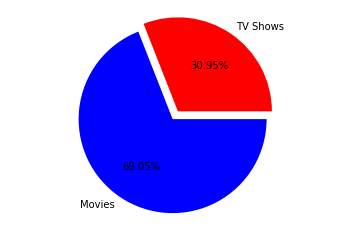

In [31]:
#Comparing the number of elements
numMovies = len(movies.index)
print(numMovies)
numTVshows = len(TVshows.index)
print(numTVshows)
colors = ['r', 'b']
tags = 'TV Shows', 'Movies'
num = [numTVshows, numMovies]
fig1, ax1 = plt.subplots()
ax1.pie(num, explode=(0.1, 0), labels=tags, colors=colors, autopct='%2.2f%%')
ax1.axis('equal')
plt.show()

# Preprocessing for NLP

In [35]:
features = ['director', 'cast', 'country', 'description', 'listed_in']
for feature in features:
    movies[feature] = movies[feature].fillna('')
def combine_features(row):
    return row['director']+""+ row['cast']+""+row['country']+""+row['description']+""+row['listed_in']
movies['combined_features']=movies.apply(combine_features, axis=1)
print("combine features", movies['combined_features'])

combine features 0       Jorge Michel GrauDemián Bichir, Héctor Bonilla...
1       Gilbert ChanTedd Chan, Stella Chung, Henley Hi...
2       Shane AckerElijah Wood, John C. Reilly, Jennif...
3       Robert LuketicJim Sturgess, Kevin Spacey, Kate...
4       Yasir Al YasiriAmina Khalil, Ahmed Dawood, Tar...
                              ...                        
5372    Peter HewittTim Allen, Courteney Cox, Chevy Ch...
5373    Josef FaresImad Creidi, Antoinette Turk, Elias...
5374    Mozez SinghVicky Kaushal, Sarah-Jane Dias, Raa...
5375    Nasty CIn this documentary, South African rapp...
5376    Sam DunnUnited Kingdom, Canada, United StatesT...
Name: combined_features, Length: 5377, dtype: object


# NLP: Recommend Movies!

In [73]:
cv = CountVectorizer()
countMatrix = cv.fit_transform(movies["combined_features"])
cosSim = cosine_similarity(countMatrix)
def title_from_index(index):
    return movies[movies.index==index]["title"].values[0]
def title_from_index(df, index):
    return df[df.index==index]["title"].values[0]
def index_from_title(df, title):
    return df[df.title==title]["index"].values[0]
def selectMovie(likedMovies):
    try:
        likedMovies = likedMovies.lower()
        movieID = index_from_title(movies, likedMovies)
        similarMovies = list(enumerate(cosSim[movieID]))
        sortSimMovies = sorted(similarMovies, key=lambda x:x[1], reverse= True)[1:]
        i=0
        print("Top 5 similar movies to "+likedMovies+"are:\n")

        for m in sortSimMovies:
            print(title_from_index(movies, m[0]))
            i= i+ 1
            if i>=5:
                break
                
    except:
        print("The movie has not been found on Netflix!")

In [74]:
selectMovie("automata")

Top 5 similar movies to automataare:

bhavesh joshi superhero
iboy
sweetheart
adhugo
the birth reborn
